## NN3 Model for Fair Value Estimation

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

df_NN3_Quintile_Signal = pd.DataFrame(index=list_company)
df_NN3_Decile_Signal = pd.DataFrame(index=list_company)
df_NN3_20_Divided_Signal = pd.DataFrame(index=list_company)
df_NN3_Percentile_Signal = pd.DataFrame(index=list_company)

for i in list_1:
    # Baseline NN3 model
    model_nn3 = Sequential()
    model_nn3.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1), input_shape=(21,))) # Input layer
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1))) # hidden layer 1
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
    model_nn3.add(Dropout(0.1))
    model_nn3.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1))) # hidden layer 3
    model_nn3.add(Dropout(0))
    model_nn3.add(Dense(1, activation='linear')) # Output layer
    model_nn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn3.fit(X_train, y_train, epochs=50, callbacks=[callback])
    y_fair = model_nn3.predict(X_test)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.join(y_final['Quintile_Rank'].rename(test_date), how='left')
    df_NN3_Decile_Signal = df_NN3_Decile_Signal.join(y_final['Decile_Rank'].rename(test_date), how='left')
    df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(test_date), how='left')
    df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.join(y_final['Percentile_Rank'].rename(test_date), how='left')

### (1) Performance Analysis

In [33]:
df_199804_199809 = pd.DataFrame(columns=date_list[:6], index=list_company)
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)

df_NN3_Quintile_Signal = pd.concat([df_199804_199809, df_NN3_Quintile_Signal, df_202206], axis=1)
df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.fillna(0).T
df_NN3_Quintile_Signal = df_NN3_Quintile_Signal.shift(1).dropna()

df_NN3_Decile_Signal = pd.concat([df_199804_199809, df_NN3_Decile_Signal, df_202206], axis=1)
df_NN3_Decile_Signal = df_NN3_Decile_Signal.fillna(0).T
df_NN3_Decile_Signal = df_NN3_Decile_Signal.shift(1).dropna()

df_NN3_20_Divided_Signal = pd.concat([df_199804_199809, df_NN3_20_Divided_Signal, df_202206], axis=1)
df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.fillna(0).T
df_NN3_20_Divided_Signal = df_NN3_20_Divided_Signal.shift(1).dropna()

df_NN3_Percentile_Signal = pd.concat([df_199804_199809, df_NN3_Percentile_Signal, df_202206], axis=1)
df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.fillna(0).T
df_NN3_Percentile_Signal = df_NN3_Percentile_Signal.shift(1).dropna()

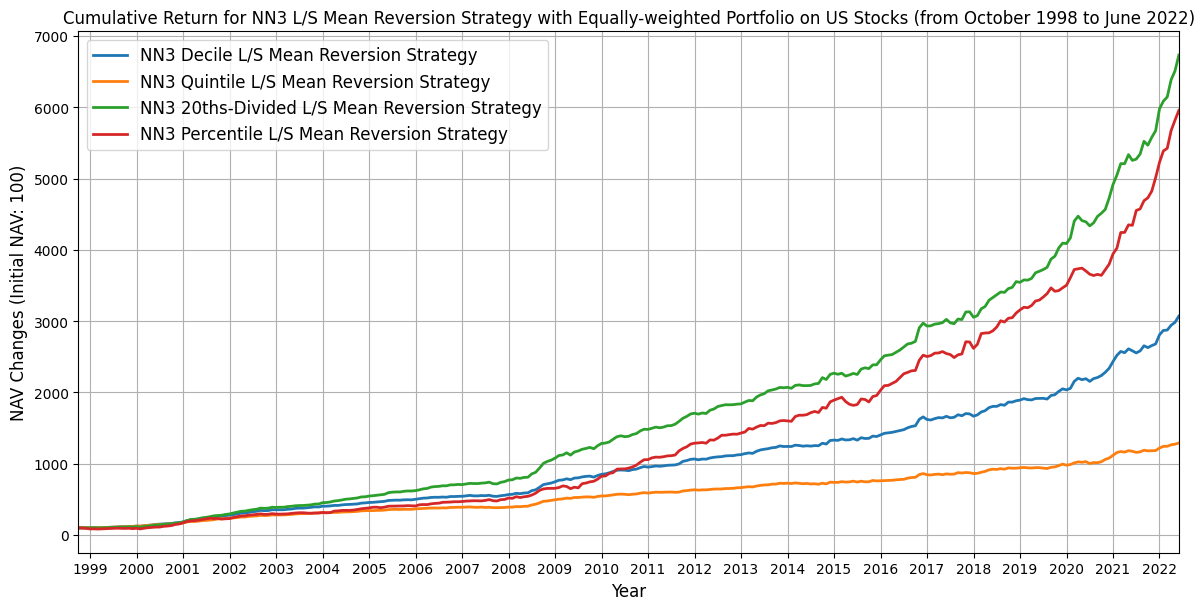

In [188]:
cum_NN3_Q_strategy_return = get_price_df(df_NN3_Quintile_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_D_strategy_return = get_price_df(df_NN3_Decile_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_T_strategy_return = get_price_df(df_NN3_20_Divided_Signal, df_returns, nav=100, model_type='ML')
cum_NN3_P_strategy_return = get_price_df(df_NN3_Percentile_Signal, df_returns, nav=100, model_type='ML')

cum_NN3_strategy_return = pd.concat([cum_NN3_D_strategy_return.rename('NN3 Decile L/S Mean Reversion Strategy'),
                                     cum_NN3_Q_strategy_return.rename('NN3 Quintile L/S Mean Reversion Strategy'),
                                     cum_NN3_T_strategy_return.rename('NN3 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_NN3_P_strategy_return.rename('NN3 Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_NN3_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for NN3 L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from October 1998 to June 2022)',
          fontsize=12)
plt.show()

In [226]:
# Performance Stats
stats_NN3_Q = get_performance_stats(cum_NN3_Q_strategy_return, rfr=risk_free_rate_df, label='NN3 Quintile (Initial NAV: 100)')
stats_NN3_D = get_performance_stats(cum_NN3_D_strategy_return, rfr=risk_free_rate_df, label='NN3 Decile (Initial NAV: 100)')
stats_NN3_T = get_performance_stats(cum_NN3_T_strategy_return, rfr=risk_free_rate_df, label='NN3 20ths (Initial NAV: 100)')
stats_NN3_P = get_performance_stats(cum_NN3_P_strategy_return, rfr=risk_free_rate_df, label='NN3 Percentile (Initial NAV: 100)')
NN3_stats = pd.concat([stats_NN3_Q, stats_NN3_D, stats_NN3_T, stats_NN3_P], axis=0)
display(NN3_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN3 Quintile (Initial NAV: 100),10.972314,0.110189,0.018682,0.050041,1.828627,0.834326,1.347156,1197.231356,2022-06-30,0.026859,2020-06-30,2020-07-31,2020-10-31,123
NN3 Decile (Initial NAV: 100),30.093040,0.155710,0.018682,0.058478,2.343220,0.905921,1.822998,3109.304005,2022-06-30,0.028855,2021-05-31,2021-07-31,2021-11-30,183
NN3 20ths (Initial NAV: 100),72.639271,0.198437,0.018682,0.068284,2.632460,0.786990,2.888233,7363.927076,2022-06-30,0.023392,2021-05-31,2021-07-31,2021-09-30,122
NN3 Percentile (Initial NAV: 100),46.942264,0.176975,0.018682,0.096788,1.635446,-0.034056,2.962242,4794.226423,2022-06-30,0.045831,2020-03-31,2020-08-31,2020-12-31,275


In [227]:
stats2_NN3_Q = get_performance_stats_2(df_NN3_Quintile_Signal, df_returns, df_market_cap, label='NN3 Quintile', model_type='ML')
stats2_NN3_D = get_performance_stats_2(df_NN3_Decile_Signal, df_returns, df_market_cap, label='NN3 Decile', model_type='ML')
stats2_NN3_T = get_performance_stats_2(df_NN3_20_Divided_Signal, df_returns, df_market_cap, label='NN3 20ths', model_type='ML')
stats2_NN3_P = get_performance_stats_2(df_NN3_Percentile_Signal, df_returns, df_market_cap, label='NN3 Percentile', model_type='ML')
NN3_stats2 = pd.concat([stats2_NN3_Q, stats2_NN3_D, stats2_NN3_T, stats2_NN3_P], axis=0)
display(NN3_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
NN3 Quintile (Long & Short),10.972314,0.008749,3.277610e+10,0.713793,0.091682,-0.077366,0.507571,0.520802,0.496437,408.686207
(Long Position),1311.086156,0.025511,1.105542e+09,0.703448,0.103030,-0.073202,0.569466,0.588317,0.553847,187.710345
(Short Position),-0.945341,-0.010147,6.202225e+10,0.379310,0.064674,-0.071379,0.450701,0.459761,0.442969,224.931034
NN3 Decile (Long & Short),30.093040,0.012133,4.936544e+10,0.762069,0.092555,-0.073973,0.519506,0.537226,0.504721,295.706897
(Long Position),9000.009826,0.032463,1.056606e+09,0.751724,0.103767,-0.065201,0.595738,0.625358,0.571645,138.451724
(Short Position),-0.947396,-0.010280,9.187197e+10,0.393103,0.065275,-0.071947,0.452815,0.462102,0.444893,158.148276
NN3 20ths (Long & Short),72.639271,0.015199,7.863899e+10,0.800000,0.093000,-0.071051,0.535243,0.558743,0.515690,192.100000
(Long Position),55661.240658,0.039085,1.305014e+09,0.817241,0.103067,-0.054960,0.634114,0.675958,0.600282,99.958621
(Short Position),-0.954311,-0.010769,1.426163e+11,0.379310,0.066499,-0.073605,0.453898,0.465021,0.444422,92.496552
NN3 Percentile (Long & Short),46.942264,0.013672,2.356793e+11,0.737931,0.091445,-0.078529,0.558481,0.564493,0.553156,51.068966


In [53]:
cum_NN3_Q_strategy_return_L = get_price_df(df_NN3_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN3_Q_strategy_return_S = get_price_df(df_NN3_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_NN3_D_strategy_return_L = get_price_df(df_NN3_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_NN3_D_strategy_return_S = get_price_df(df_NN3_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_NN3_Q_L = get_performance_stats(cum_NN3_Q_strategy_return_L, rfr=risk_free_rate_df, label='NN3 Quintile L (Initial NAV: 100)')
stats_NN3_Q_S = get_performance_stats(cum_NN3_Q_strategy_return_S, rfr=risk_free_rate_df, label='NN3 Quintile S (Initial NAV: 100)')
stats_NN3_D_L = get_performance_stats(cum_NN3_D_strategy_return_L, rfr=risk_free_rate_df, label='NN3 Decile L (Initial NAV: 100)')
stats_NN3_D_S = get_performance_stats(cum_NN3_D_strategy_return_S, rfr=risk_free_rate_df, label='NN3 Decile S (Initial NAV: 100)')
NN3_stats3 = pd.concat([stats_NN3_Q_L, stats_NN3_Q_S, stats_NN3_D_L, stats_NN3_D_S], axis=0)
display(NN3_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
NN3 Quintile L (Initial NAV: 100),1328.453456,0.353702,0.018682,0.168617,1.986863,0.359533,0.531813,148544.423494,2021-10-31,0.105013,2021-10-31,2022-06-30,Yet to recover,Yet to recover
NN3 Quintile S (Initial NAV: 100),6.873907,0.090773,0.018682,0.169086,0.426353,-0.467468,1.276788,1064.147202,2021-08-31,0.260074,2021-08-31,2022-06-30,Yet to recover,Yet to recover
NN3 Decile L (Initial NAV: 100),7098.941888,0.452640,0.018682,0.156629,2.770611,0.586410,0.901572,756542.409932,2022-03-31,0.061528,2022-03-31,2022-06-30,Yet to recover,Yet to recover
NN3 Decile S (Initial NAV: 100),5.918770,0.084850,0.018682,0.177353,0.373084,-0.408330,1.599747,996.370439,2021-08-31,0.305603,2021-08-31,2022-06-30,Yet to recover,Yet to recover


### (2) Hyperparameters Tuning

In [48]:
validation_date = ['1998-08', '1998-09']

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]


X_temp = X[X.datadate.isin(validation_date)]
X_temp.set_index(['cusip', 'datadate'], inplace=True)
X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
X_norm.reset_index(inplace=True)
X_validation = X_norm[X_norm.datadate.isin(validation_date)]
X_validation = X_validation.iloc[:, 2:]
X_validation = np.array(X_validation)

y_validation = y[y.datadate.isin(validation_date)]
y_validation = y_validation.iloc[:, 2]
y_validation = np.array(y_validation)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [49]:
def creating_nn3(hp):
    model = Sequential()

    unit1 = hp.Int('Input_layer',min_value=1, max_value = 21, step = 1)
    unit2 = hp.Int('lay1',min_value=1, max_value = 21, step = 1)
    unit3 = hp.Int('lay2',min_value=1, max_value = 21, step = 1)
    unit4 = hp.Int('lay3',min_value=1, max_value = 21, step = 1)
    unit5 = hp.Float('dropout1', min_value=0, max_value=0.7, step=0.1)
    unit6 = hp.Float('dropout2', min_value=0, max_value=0.7, step=0.1)
    unit7 = hp.Float('dropout3', min_value=0, max_value=0.7, step=0.1)
    unit8 = hp.Float('dropout4', min_value=0, max_value=0.7, step=0.1)
    unit9 = hp.Choice('regularization', values = [1e-1, 1e-2, 1e-3])
    unit10 = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='tanh')
    learning_rate1  = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])


    model.add(Dense(unit1, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9), input_shape=(21,)))
    model.add(Dropout(unit5))
    model.add(Dense(unit2, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit6))
    model.add(Dense(unit3, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit7))
    model.add(Dense(unit4, activation=unit10, kernel_regularizer=regularizers.l2(unit9),
                    bias_regularizer=regularizers.l2(unit9)))
    model.add(Dropout(unit8))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate1), loss='mse', metrics=['mae'])

    return model

In [ ]:
tuner_nn3 = kt.Hyperband(creating_nn3, objective='val_loss', max_epochs=50, project_name='nn3_tuning_1', overwrite=True)
tuner_nn3.search(X_validation, y_validation, epochs=50, validation_data=(X_validation, y_validation), callbacks=[callback], batch_size=32)

In [ ]:
tuner_nn3.results_summary()

In [ ]:
"""
Hyperparameters:
Input_layer: 20
lay1: 13
lay2: 11
lay3: 17
dropout1: 0.2
dropout2: 0.2
dropout3: 0.1
dropout4: 0
regularization: 0.1
dense_activation: relu
learning_rate: 0.01
tuner/epochs: 50
"""

### (3) Feature Importance

In [ ]:
date_list_1 = date_list[:-6]
list_1 = range(len(date_list_1))

raw_2 = df_target_features.copy()
raw_2.reset_index(inplace=True)
raw_2['datadate'] = raw_2['datadate'].astype('str')

X = raw_2.drop('Market_Cap', axis=1)
y = raw_2[['cusip', 'datadate', 'Market_Cap']]
y.set_index(['cusip', 'datadate'], inplace=True)
y = y / 10000000
y.reset_index(inplace=True)

nn3_importances_df = pd.DataFrame(index=feature_names)

for i in list_1:
    # Baseline NN3 model
    model_nn3 = Sequential()
    model_nn3.add(Dense(20, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1), input_shape=(21,))) # Input layer
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(13, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1))) # hidden layer 1
    model_nn3.add(Dropout(0.2))
    model_nn3.add(Dense(11, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1))) # hidden layer 2
    model_nn3.add(Dropout(0.1))
    model_nn3.add(Dense(17, activation='relu', kernel_regularizer=regularizers.l2(0.1),
                        bias_regularizer=regularizers.l2(0.1))) # hidden layer 3
    model_nn3.add(Dropout(0))
    model_nn3.add(Dense(1, activation='linear')) # Output layer
    model_nn3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

    temp_date = date_list[i:i+7]
    # train the model with 6 months as the rolling window of the data
    train_date = date_list[i:i+6]
    # use the model to calculate the 7th month's fair value
    test_date = date_list[i+6]

    X_temp = X[X.datadate.isin(temp_date)]
    X_temp.set_index(['cusip', 'datadate'], inplace=True)
    X_norm = X_temp.apply(lambda j: (j - j.mean()) / j.std())
    X_norm.reset_index(inplace=True)

    X_train = X_norm[X_norm.datadate.isin(train_date)]
    X_train = X_train.iloc[:, 2:]
    X_train = np.array(X_train)

    X_test = X_norm[X_norm.datadate == test_date]
    X_test = X_test.iloc[:, 2:]
    X_test = np.array(X_test)

    y_train = y[y.datadate.isin(train_date)]
    y_train = y_train.iloc[:, 2]
    y_train = np.array(y_train)

    y_temp = y[y.datadate == test_date]
    y_test = y_temp.iloc[:, 2]
    y_test = np.array(y_test)

    model_nn3.fit(X_train, y_train)
    perm_nn3 = PermutationImportance(model_nn3, scoring='neg_mean_squared_error', random_state=random_state).fit(X_test, y_test)
    nn3_importances_1 = pd.Series(perm_nn3.feature_importances_, index=feature_names)
    nn3_f = nn3_importances_1 / abs(nn3_importances_1).sum()
    nn3_importances_df = pd.concat([nn3_importances_df, nn3_f], axis=1)

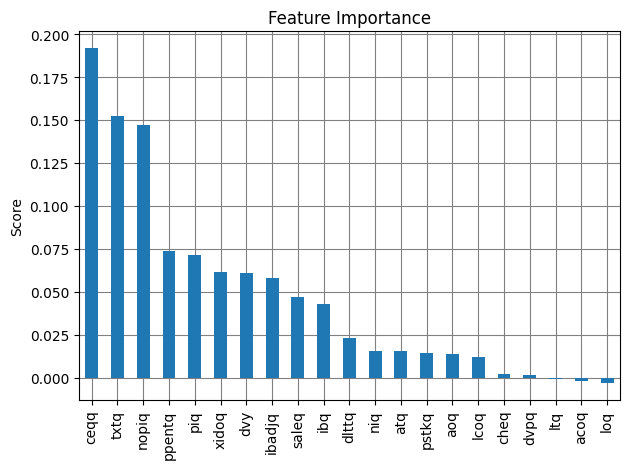

In [379]:
nn3_avg_importance = nn3_importances_df.mean(axis=1).sort_values(ascending=False)
fig, ax3 = plt.subplots()
nn3_avg_importance.plot.bar(ax=ax3)
ax3.set_axisbelow(True)
ax3.grid(color='gray')
ax3.set_title('Feature Importance')
ax3.set_ylabel('Score')
fig.tight_layout()
plt.show()